In [130]:
library(knitr)
library(sqldf)
library(ggplot2)
library(mongolite)
library(ggplot2)
library(gridExtra)
library(dplyr)
library(tidyr)
library(jsonlite)
library(lubridate)
library(gridExtra)
library(GGally)
library(scales)
library(memisc)
 library(sp)
library(rgeos)
library(rgdal)
library(maptools)
library(RColorBrewer)
library(maps)
library(grid)
library(cluster)
#library(clue)
#library(StatMatch)
library(fastcluster)
library(factoextra)
library(FactoMineR)
library(stringr)
library(googleVis)
library(RMySQL)
library(data.table)
library(dbplyr)
library(DBI)
library(httr)
library(scanstatistics)
library(purrr)
library(magrittr)
library(rsatscan)
library(MASS)
library(readr)
library(caret)
library(fitdistrplus)
library(pscl)
library(car)
library(AUC)
library(ROCR)
library(actuar)
#.libPaths(c(file.path(Sys.getenv('SPARK_HOME'), 'R', 'lib'), .libPaths())

#### Continuing from EDA

EDA notebook found three high level clusters or populations of tweet counts in time.
This notebook examines the positive sentiment tweets created in the Sentiments notebook.
Distribution of positive tweets and possible baseline models that can fit the data at the global level without creating any local, regional or geographical clusters.
Comparison of these models to the clustered approach used in Space Time Scan Statistics (STSS)

In [12]:
plot.format <- theme(axis.text = element_text(size = 12), legend.text = element_text(size = 12), legend.title = element_text(size = 12), axis.title = element_text(size = 14), plot.title = element_text(size = 14))

In [ ]:
#### Load tweet related data

In [11]:
full_text_en <- fread(file="../STSS/Files/Lexicon/full_text_en2_dc.csv", sep =",", 
                      header = TRUE, 
              stringsAsFactors=FALSE,
             showProgress=getOption("datatable.showProgress", interactive()), 
                      data.table=FALSE)

In [ ]:
### Get text for USA city locations only

In [13]:
full_text_en_usa <- full_text_en %>%
                                filter(!is.na(City_code)) %>%
                                as.data.frame()

In [12]:
full_text_en_usa$V1 <-NULL
str(full_text_en_usa)

'data.frame':	932321 obs. of  42 variables:
 $ rowno                      : num  1 2 4 5 17 18 25 32 38 43 ...
 $ user.id                    :integer64 1539100118 9439062 1539100118 9439062 19313747 39109570 20966032 598130172 ... 
 $ user.location              : chr  "Columbus, OH" "Atlanta, GA" "Columbus, OH" "Atlanta, GA" ...
 $ user.description           : chr  "Advocate for survivors of sexual violence. Breaker of silence, destroyer of shame." "Husband. Father. Prelate. Human. Company builder, 2 exits. Author @kingonomics. Inclusive ecosystem builder @th"| __truncated__ "Advocate for survivors of sexual violence. Breaker of silence, destroyer of shame." "Husband. Father. Prelate. Human. Company builder, 2 exits. Author @kingonomics. Inclusive ecosystem builder @th"| __truncated__ ...
 $ created_at                 : chr  "Sat Aug 09 22:33:06 +0000 2014" "Sat Aug 09 22:59:13 +0000 2014" "Sat Aug 09 22:28:42 +0000 2014" "Sat Aug 09 23:03:05 +0000 2014" ...
 $ id                      

In [ ]:
### Load sentiment data using customised NRC Emotions lEXICON 

In [131]:
sentiment.pos <- read.csv("../Sentiment/Files/Sentiment/sentiment_pos_nrc.csv", 
         stringsAsFactors = FALSE)

In [6]:
str(sentiment.pos)

'data.frame':	902725 obs. of  27 variables:
 $ textnum              : num  1 2 4 5 17 18 25 32 38 43 ...
 $ retweeted            : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ retweet              : int  0 0 0 0 1 1 1 0 1 0 ...
 $ favorited            : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ favorite_count       : int  107 1 10 2 0 0 0 0 0 3 ...
 $ yday                 : int  221 221 221 221 221 221 221 221 221 221 ...
 $ possibly_sensitive   : logi  NA NA NA NA NA NA ...
 $ tweet_type           : chr  "All" "SB" "All" "All" ...
 $ keyword_pos_hash     : chr  "c(120, 128)" "c(87, 98, 96, 109)" "c(50, 60, 58, 67)" "c(25, 33)" ...
 $ keyword_count_hash   : int  1 2 2 1 2 2 2 2 2 1 ...
 $ full_text_low        : chr  "black teenage boys are not men they are children stop referring to a year old as a man you are killing children " " while there please tune in todays killing of the young black male in " "sick and tired of police killing unarmed people " "well here we go again "

In [18]:
colnames(sentiment.pos)

[1] "textnum"               "retweeted"             "retweet"              
 [4] "favorited"             "favorite_count"        "yday"                 
 [7] "possibly_sensitive"    "tweet_type"            "keyword_pos_hash"     
[10] "keyword_count_hash"    "full_text_low"         "full_text_low_nostop" 
[13] "lon"                   "lat"                   "location_total.counts"
[16] "location"              "City2"                 "Code"                 
[19] "element_id"            "sentence_id"           "word_count"           
[22] "sentiment"             "positive"              "negative"             
[25] "neutral"               "time"                  "labels"

In [ ]:
### Amount of positive sentiment tweets - based on the distribution of sentiment postive 
### is taken as  >= 0.15

In [19]:
round(NROW(subset(sentiment.pos$sentiment,sentiment.pos$sentiment >= 0.15))/NROW(sentiment.pos$sentiment) * 100, 2)

[1] 27.76

In [ ]:
### Generate count data for positive, negative, neutral and total counts for each location 
### and day data point

In [20]:
count.pos <- sentiment.pos %>% dplyr::select(one_of(c("yday", 
                                                      "location", "time", 
                                               "lon", 
                                              "lat", "location_total.counts", 
                                               "positive",
                                               "negative", 
                                                      "neutral"))) %>%
                                 mutate(lon = as.character(lon), 
                                          lat = as.character(lat)) %>%
                                filter(!(is.na(lon) & is.na(lat))) %>%
                                group_by(yday, location, lon, 
                                              lat, 
                                         location_total.counts, time) %>%
                                mutate(positive.counts = 
                                       sum(positive), 
                                       negative.counts = 
                                       sum(negative),
                                       neutral.counts = 
                                       sum(neutral),
                                       counts = positive.counts + 
                                                   negative.counts +
                                                   neutral.counts
                                       
                                      ) %>%
                                dplyr::select(-positive, -negative, 
                                              -neutral) %>%
                                group_by(yday, location, time, 
                                         location_total.counts,
                                         positive.counts, 
                                         negative.counts,
                                            neutral.counts, counts) %>%
                                       
                                       summarise(lon = 
                                                  mean(as.numeric(lon), 
                                                       na.rm = TRUE), 
                                                  lat = 
                                                  mean(as.numeric(lat), 
                                                       na.rm = TRUE)) %>%
                                                   
                                distinct() %>%
                                as.data.frame()
                    

In [17]:
head(count.pos[c("location", "time", "counts", "positive.counts", "negative.counts", "neutral.counts")])

location,time,counts,positive.counts,negative.counts,neutral.counts
ATLANTA GA,1,7,2,4,1
AUSTIN TX,1,2,0,1,1
BALTIMORE MD,1,2,0,2,0
BEAVERTON OR,1,2,0,1,1
BOSTON MA,1,2,0,1,1
BOULDER CO,1,1,0,0,1


In [21]:
summary(subset(count.pos$positive.counts, count.pos$positive.counts >= 0))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.00    1.00   10.45    3.00 5236.00 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


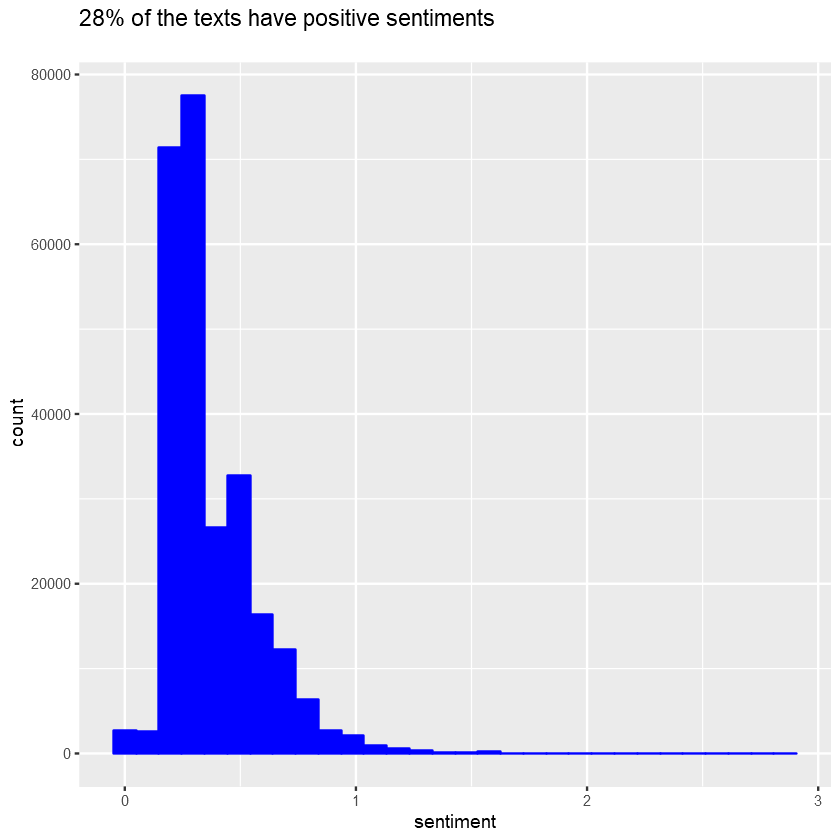

In [72]:
ggplot(aes(x = sentiment), data = subset(sentiment.pos, sentiment > 0)) +
geom_histogram(color = "blue", fill = "blue") +
#geom_bar(color = "blue", fill = "blue", stat = "summary", fun.y = sum) +
#geom_smooth(method = "", formula = "y ~ exp(x)") +
#scale_x_continuous(limits = c(-1, 1), breaks = seq(-1, 1, 0.1)) +
#scale_x_log10() +
labs(title = "28% of the texts have positive sentiments\n")

write.csv(count.pos, "C:\\MathLabASUS\\Courses\\Ryerson\\Project\\Data\\Files\\Sentiment\\count_pos2.csv", 
         row.names = FALSE)

In [ ]:
### Placeholder to load count.pos2.csv file

count.pos <- read.csv("../STSS/Files/STSS/count_pos2.csv", 
         stringsAsFactors = FALSE)

In [ ]:
###### Load features data

In [22]:
feat <- read.csv("../STSS/Files/Features/features2dc.csv"
#Features/features2dc.csv"
                 , stringsAsFactors = FALSE)

In [ ]:
#### Remove any duplicates

In [23]:
feat.nodup <- feat %>% group_by(location, add = FALSE) %>%
                arrange(desc(totalpopulation)) %>%
                top_n(1, totalpopulation) %>%
                as.data.frame()

write.csv(feat.nodup, "C:\\MathLabASUS\\Courses\\Ryerson\\Project\\Data\\Files\\Features_Demo\\features2dc_nodup.csv", 
          row.names = FALSE)

In [ ]:
#### Placeholder to load features data

feat.nodup <- read.csv("../STSS/Files/Features/features2dc_nodup.csv", 
          stringsAsFactors = FALSE)

In [ ]:
### Add city population to daily spatial count data

In [24]:
features <- feat.nodup[c("location", "totalpopulation", 
                         "lon", "lat", 
                          "count")]

In [25]:
count.pos.pop <- count.pos %>% inner_join(features %>% 
                                           dplyr::select(-count, 
                                                         -lon, -lat),
                                     by = c("location")) %>%
                                as.data.frame()

write.csv(count.pos.pop, "C:\\MathLabASUS\\Courses\\Ryerson\\Project\\Data\\Files\\Sentiment\\count_pos_pop2.csv", 
         row.names = FALSE)

In [52]:
nrow(count.pos.pop)

[1] 22407

In [ ]:
#### Place holder to load daily counts and population data

count.pos.pop <- read.csv("../STSS/Files/STSS/count_pos_pop2.csv", 
         stringsAsFactors = FALSE)

In [ ]:
#### Create a dataframe for total spatial counts (i.e. no temporal componnt)

In [75]:
count.pos.spat <- count.pos %>% dplyr::select(-yday, -time) %>%
                                group_by(location, lon, lat) %>%
                                summarise(counts = sum(counts), 
                                         positive.counts = 
                                          sum(positive.counts),
                                         negative.counts = 
                                          sum(negative.counts), 
                                          neutral.counts = 
                                          sum(neutral.counts)
                                         ) %>%
                                
                              #  distinct() %>%
                                as.data.frame()

write.csv(count.pos.spat, "C:\\MathLabASUS\\Courses\\Ryerson\\Project\\Data\\Files\\Sentiment\\count_pos_spat2.csv", 
         row.names = FALSE)

count.pos.spat <- read.csv("../STSS/Files/STSS/count_pos_spat2.csv", 
         stringsAsFactors = FALSE)

In [ ]:
### Create a dataframe to add demographic data to sentiment counts data - all cities

In [76]:
count.pos.spat.feat <- count.pos.spat %>% 
                                mutate(lon = as.numeric(lon), 
                                 lat = as.numeric(lat)) %>%
                                inner_join(features %>% 
                                           dplyr::select(-count, -lon, 
                                                         -lat),
                                     by = c("location")
                                          ) %>% 
                            #dplyr::rename("location" = "City_code") %>%
                       #     distinct() %>%
                            as.data.frame()

write.csv(count.pos.spat.feat, "C:\\MathLabASUS\\Courses\\Ryerson\\Project\\Data\\Files\\Sentiment\\count_pos_spat_feat2.csv", 
         row.names = FALSE)

In [ ]:
### Placeholder to load location (spatial only) counts and demographic 
### data

count.pos.spat.feat <- read.csv("../STSS/Files/STSS/count_pos_spat_feat2.csv", 
         stringsAsFactors = FALSE)

In [35]:
#### Statistics on positive sentiment counts for each location

In [26]:
summary(count.pos.pop$positive.counts)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       1      11       3    5236 

### Run statistical tests and analyze the data for modelling

In [27]:
cor.test(count.pos.pop$positive.counts, count.pos.pop$totalpopulation)


	Pearson's product-moment correlation

data:  count.pos.pop$positive.counts and count.pos.pop$totalpopulation
t = 66.262, df = 22405, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3937866 0.4156836
sample estimates:
      cor 
0.4047931 


In [235]:
summary(count.pos.pop$positive.counts)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       1      11       3    5236 

In [114]:
### % of zeros in the data

In [79]:
round(nrow(subset(count.pos.pop, positive.counts 
                  == 0))/nrow(count.pos.pop) *  100, 2)

[1] 39.58

###### Test for a Poisson distribution at the global level.

In [28]:
lambda.pos <- fitdistr(count.pos.pop$positive.counts, "poisson")
lambda.neg <- fitdistr(count.pos.pop$negative.counts, "poisson")

In [29]:
lambda.pos
lambda.neg

     lambda  
  10.9988396 
 ( 0.0221555)

     lambda   
  10.86812157 
 ( 0.02202345)

In [30]:
poisson.test(sum(count.pos.pop$positive.counts), lambda.pos$estimate, 
             alternative = "greater")


	Exact Poisson test

data:  sum(count.pos.pop$positive.counts) time base: lambda.pos$estimate
number of events = 246450, time base = 10.999, p-value < 2.2e-16
alternative hypothesis: true event rate is greater than 1
95 percent confidence interval:
 22332.81      Inf
sample estimates:
event rate 
     22407 


In [31]:
poisson.test(sum(count.pos.pop$negative.counts), 
             lambda.neg$estimate, 
             alternative = "greater")


	Exact Poisson test

data:  sum(count.pos.pop$negative.counts) time base: lambda.neg$estimate
number of events = 243520, time base = 10.868, p-value < 2.2e-16
alternative hypothesis: true event rate is greater than 1
95 percent confidence interval:
 22332.37      Inf
sample estimates:
event rate 
     22407 


In [ ]:
Count data does not follows a spatial poisson distribution. 
True event rate >> 1. p-value << 0.05. Accept alternative hypothesis.

#### Test for overdispersion in the positive count data and the city population data

In [ ]:
#### Mean of data empirical data

In [80]:
cat("Mean of positive count data: ")
mean(count.pos.pop$positive.counts)
cat("\nMean of positive count data - zero inflated data removed: ")
mean(subset(count.pos.pop, positive.counts > 0)$positive.counts)

Mean of positive count data: 

[1] 10.99884


Mean of positive count data - zero inflated data removed: 

[1] 18.20304

In [ ]:
##### Variance of empirical data

In [81]:
cat("Variance in positive count data: ")
var(count.pos.pop$positive.counts)
cat("\nVariance in positive count data - zero inflated data removed: ")
var(subset(count.pos.pop, positive.counts > 0)$positive.counts)

Variance in positive count data: 

[1] 9536.443


Variance in positive count data - zero inflated data removed: 

[1] 15652.09

In [ ]:
Variance >> Mean both with and without zeros. This shows that overdispersion 
still occurs with non-zero small count data
Test degree of dispersion using standard poisson glm model

In [ ]:
#### Positive count data overdispersion test

In [82]:
disp.test <- glm(positive.counts ~ 1, data = count.pos.pop, 
                 family = "poisson")

In [83]:
summary(disp.test)


Call:
glm(formula = positive.counts ~ 1, family = "poisson", data = count.pos.pop)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
 -4.690   -4.690   -3.899   -2.864  232.627  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) 2.397790   0.002014    1190   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 1452232  on 22406  degrees of freedom
Residual deviance: 1452232  on 22406  degrees of freedom
AIC: 1493754

Number of Fisher Scoring iterations: 8


In [84]:
logLik(disp.test)

'log Lik.' -746875.9 (df=1)

In [85]:
cat("Dispersion:") 
disp.test$deviance/disp.test$df.residual

Dispersion:

[1] 64.81442

In [ ]:
#### City population data overdispersion test

In [129]:
disp.test <- glm(totalpopulation ~ 1, data = count.pos.pop, 
                 family = "poisson")

In [127]:
summary(disp.test)


Call:
glm(formula = positive.counts ~ 1, family = "poisson", data = count.pos.pop)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
 -4.690   -4.690   -3.899   -2.864  232.627  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) 2.397790   0.002014    1190   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 1452232  on 22406  degrees of freedom
Residual deviance: 1452232  on 22406  degrees of freedom
AIC: 1493754

Number of Fisher Scoring iterations: 8


In [167]:
logLik(disp.test)

'log Lik.' -778100.6 (df=1)

In [149]:
cat("Dispersion:") 
disp.test$deviance/disp.test$df.residual

Dispersion:

[1] 78.38492

The summary data for count.pos shows positive counts is both overdispered (wrt zeros) and zero-inflated.
64.81 >> 1. In addition a dispersion test for totalpopulation = 78.4

The code below tests for distributions that best fits the non-zero portions of the 
overdispered data.
Note: The poisson model in the glm function fixes the dispersion parameter = 1

1. Two ways are zero inflated negbin and zero inflated poisson. 
2. Another way is seperate the count model (gamma) from the zero model (binomial). 
3. Negative binomial is another option. Negbinomial is considered a discrete case of gamma.

In [86]:
get.par <- fitdist(subset(count.pos.pop, positive.counts 
                           > 0)$positive.counts, "gamma")

In [87]:
gof.gamma <- gofstat(get.par, fitnames = "gamma")
gof.gamma

Goodness-of-fit statistics
                                   gamma
Kolmogorov-Smirnov statistic   0.2709542
Cramer-von Mises statistic   399.3303036
Anderson-Darling statistic           Inf

Goodness-of-fit criteria
                                  gamma
Akaike's Information Criterion 92251.84
Bayesian Information Criterion 92266.87

In [88]:
ks.test(subset(count.pos.pop, positive.counts > 4)$positive.counts, "pgamma", get.par$estimate["shape"], 
        get.par$estimate["rate"], alternative = "greater")

Warning message in ks.test(subset(count.pos.pop, positive.counts > 4)$positive.counts, :
"ties should not be present for the Kolmogorov-Smirnov test"


	One-sample Kolmogorov-Smirnov test

data:  subset(count.pos.pop, positive.counts > 4)$positive.counts
D^+ = 3.914e-17, p-value = 1
alternative hypothesis: the CDF of x lies above the null hypothesis


In [46]:
summary(count.pos.pop$positive.counts)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       1      11       3    5236 

Reject null hypothesis that the data fits a gamma distribution based on filtering zeros only (not shown).
Accept the null hypothesis that the non-zero portion of 
positive count data can fit a gamma distribution only if the positive counts are greater than the 75% quantile.


Fit a zero inflated, negative binomial and/or gamma model to data.
Use a gamma model null model to create a baseline for the various GLMs.
Negbin accounts assumes data consists of multiple poisson distributions. These multiple poisson distributions themselves are gamma distributed.
Models can account for random effects in various R packages, but not the pscl package used in this project.

Locations can have random effects (e.g. negbin and gamma distribution - long tail/a few very large effects on individual locations)
Variability in the number of positive count per total population. Population used as offset in glm/negbin model

Note: type 1 (quassi poisson) and type2 (zero inflated) - negbin
Note: Used offset(log(totalpopulation)) due to poisson family of models which in turned used rates - positive counts/totalpopulation

****Zeroinflated model must have zero counts. Gamma model - has long tail data ****


###### Test correlation between total positive counts at a location and total population

In [247]:
cor.test(count.pos.spat.feat$totalpopulation, count.pos.spat.feat$positive.counts)


	Pearson's product-moment correlation

data:  count.pos.spat.feat$totalpopulation and count.pos.spat.feat$positive.counts
t = 48.568, df = 5217, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5390258 0.5764019
sample estimates:
      cor 
0.5579968 


##### Examine various GLM models to find a good baseline. 

In [ ]:
### Create train and test data

In [28]:
set.seed(20190126)
train <- count.pos.pop %>%
                group_by(location, add = FALSE) %>%
                    dplyr::sample_frac(0.75) %>%
                
            as.data.frame()

In [29]:
test <- anti_join(count.pos.pop, train) #[sample$id, ]

Joining, by = c("yday", "location", "time", "location_total.counts", "positive.counts", "negative.counts", "neutral.counts", "counts", "lon", "lat", "totalpopulation")


In [ ]:
### Null model using gamma

In [30]:
summary(glm(positive.counts ~ 1, 
                data = subset(train, positive.counts > 0),
          #  train,
    family = Gamma(link = "log")))


Call:
glm(formula = positive.counts ~ 1, family = Gamma(link = "log"), 
    data = subset(train, positive.counts > 0))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9593  -1.9593  -1.6021  -0.9092  24.1856  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.86229    0.06758   42.35   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for Gamma family taken to be 47.54811)

    Null deviance: 36325  on 10410  degrees of freedom
Residual deviance: 36325  on 10410  degrees of freedom
AIC: 70931

Number of Fisher Scoring iterations: 9


Over dispersion is still high. Dispersion = 47.55

In [ ]:
#### Gamma model

In [31]:
gamma.ml <- glm(positive.counts ~ offset(log(totalpopulation)) 
                + time, 
                data = subset(train, positive.counts > 0),
    family = Gamma(link = "log"))

In [32]:
summary(gamma.ml)


Call:
glm(formula = positive.counts ~ offset(log(totalpopulation)) + 
    time, family = Gamma(link = "log"), data = subset(train, 
    positive.counts > 0))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.9081  -1.5830  -1.0462  -0.2954  16.1187  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -8.60211    0.11397 -75.479  < 2e-16 ***
time         0.09116    0.01419   6.422  1.4e-10 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for Gamma family taken to be 14.51945)

    Null deviance: 24787  on 10410  degrees of freedom
Residual deviance: 24278  on 10409  degrees of freedom
AIC: 65291

Number of Fisher Scoring iterations: 8


In [33]:
pred.gamma <- predict(gamma.ml, 
                               newdata = 
                               subset(test, positive.counts > 0), 
                               type = "response")

In [34]:
mae.gamma <- mean(abs(pred.gamma -
                               log(subset(test, 
                                          test$positive.counts 
                                          > 0)$positive.counts)))
mae.gamma

[1] 34.85104

Performance of gamm model is better based on AIC = 65,291 compared to negative binomial and zeroinflated negative binomial. However gamma cannot completely handle the overdispersion in the the data which is still high (14.52)

In [ ]:
####### Binomial(zero) model for gamma-binomial done seperately

In [35]:
train$positive <- ifelse(train$positive.counts > 0 , 1, 0)
test$positive <- ifelse(test$positive.counts > 0 , 1, 0)

In [36]:
zero.binom <- glm(positive ~ offset(log(totalpopulation)) + 
                          time, 
                data = train,
    family = binomial(link = "logit"))

In [37]:
summary(zero.binom)


Call:
glm(formula = positive ~ offset(log(totalpopulation)) + time, 
    family = binomial(link = "logit"), data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.4941  -1.0405   0.4404   0.9029   3.3876  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -9.929463   0.054626 -181.77   <2e-16 ***
time         0.084525   0.006868   12.31   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 23963  on 17346  degrees of freedom
Residual deviance: 23812  on 17345  degrees of freedom
AIC: 23816

Number of Fisher Scoring iterations: 4


Zero portion of the combined gamma-binomial has an AIC of 23816 shows that the model can handle that part of the data.

In [38]:
pred.zero.binom <- predict(zero.binom, 
                                    newdata = test, 
                               type = "response")

In [ ]:
#### Precision = True Positives / (True Positives + False Positives)

In [39]:
ModelMetrics::precision(test$positive, pred.zero.binom, 0.5)

[1] 0.6597128

In [40]:
##### Recall = True Positives / (True Positives + False Negatives) 

In [41]:
ModelMetrics::recall(test$positive, pred.zero.binom, 0.5)

[1] 0.7784527

In [42]:
ModelMetrics::f1Score(test$positive, pred.zero.binom, 0.5)

[1] 0.714181

In [43]:
ModelMetrics::confusionMatrix(test$positive, 
                              pred.zero.binom, 0.5)

676,693
1256,2435


In [44]:
ModelMetrics::auc(test$positive, 
                              pred.zero.binom)

[1] 0.6571451

Binomial zero count model gives moderate values for precision and recall0.66 and 0.78 respectively. The auc = 0.66. 
The more up and to the left (more TPR or sensitivity) the curve, then the better the AUC - i.e. the largr the area under the curve, then the better the model performance.

In [45]:
AUC::specificity(test$positive, pred.zero.binom, perc.rank = TRUE)

$cutoffs
[1] 1.0000000 1.0000000 0.3818182 0.0000000

$measure
[1] NaN  NA  NA   0

attr(,"class")
[1] "AUC"         "specificity"

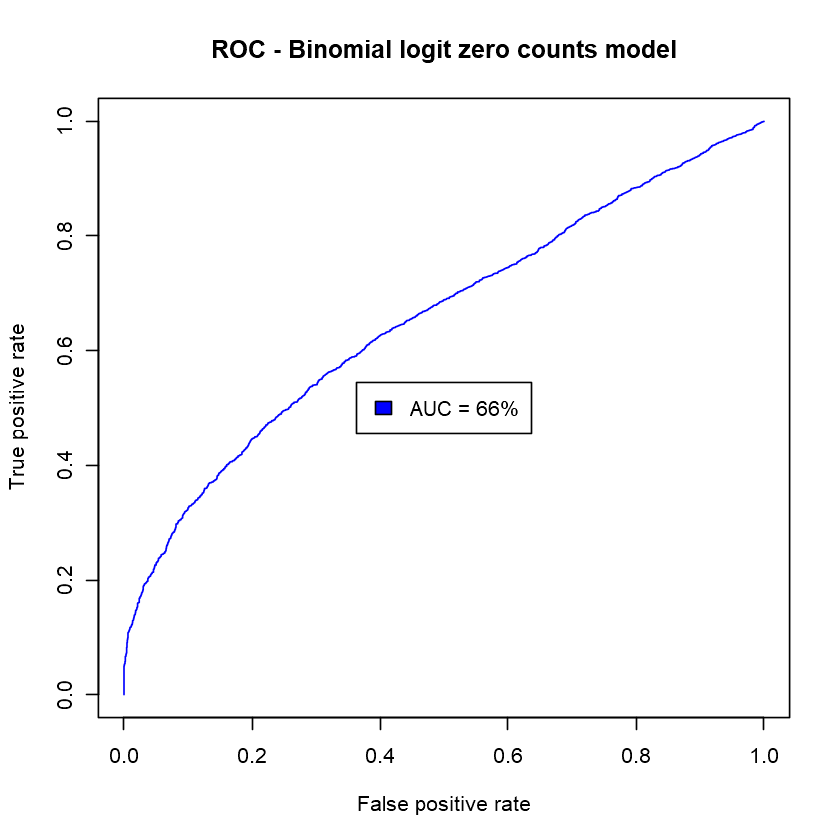

In [46]:
predict.roc <- prediction(pred.zero.binom, test$positive)
roc <- performance(predict.roc, "tpr", "fpr")
plot(roc, col = "blue", main = "ROC - Binomial logit zero counts model") 
legend(x = "center", legend = "AUC = 66%", fill = "blue")

Time  variable is significant using this model (gamma). AIC = 65,291
If locations include (lon, lat) the model performance does not change. 
AIC = 65,255 (not shown). However, lon is a significant variable (p-value = 0.1). 
Gamma model reduces the overdispersionin the data. 
Dispersion = 14.52 (non-zero data). This is in comparison to the dispersion = 62.37 of the overall data.


Checked binomial logit seperately for count data. Time is a significant variable. AIC = 23,816. Again the performance is only slightly affected by inclusion of geo-coordinates, but the spatial variables were considered highly statistically significant (p-values < 0.01). AIC = 23,774 (not shown). The AUC (ROC lift) for the binomial model = 66% which is better than a baseline model of 50%.

###### Negative binomial model

In [49]:
negbin <- glm.nb(positive.counts ~ offset(log(totalpopulation)) + time, 
       data = train, init.theta = 2, link = "log")

In [50]:
summary(negbin)


Call:
glm.nb(formula = positive.counts ~ offset(log(totalpopulation)) + 
    time, data = train, init.theta = 0.3944712303, link = "log")

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4237  -1.0756  -0.6294  -0.0328  12.0842  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -9.522678   0.039444 -241.42   <2e-16 ***
time         0.090591   0.004901   18.48   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for Negative Binomial(0.3945) family taken to be 1)

    Null deviance: 18151  on 17346  degrees of freedom
Residual deviance: 17914  on 17345  degrees of freedom
AIC: 76107

Number of Fisher Scoring iterations: 1


              Theta:  0.39447 
          Std. Err.:  0.00554 

 2 x log-likelihood:  -76100.97200 

In [51]:
pred.negbin <- predict(negbin, newdata = test, type = "response")

In [52]:
mean(abs(pred.negbin - test$positive.counts))

[1] 12.35514

Adding location variables lon and lat does not improve the model. 
AIC = 76,107 (time only) vs 76,098 (time + lon + lat). This is also reflected in the dispersion parameter theta and the Mean average error (MAE). 
Only the longitude parameter is significant. Latitude is not significant. This results is also reflected inmost GLM models examined.

In [ ]:
##### Zero inflated negative binomial

In [53]:
zi.negbin <- zeroinfl(positive.counts ~ 
                   offset(log(totalpopulation)) + time, 
                data = train, dist = "negbin", zero.dist = "binomial", 
                      link = "logit",
               control = zeroinfl.control(method = "BFGS", 
                                          maxit = 10000, EM = TRUE, 
                                         ))

In [54]:
summary(zi.negbin)


Call:
zeroinfl(formula = positive.counts ~ offset(log(totalpopulation)) + time, 
    data = train, dist = "negbin", link = "logit", control = zeroinfl.control(method = "BFGS", 
        maxit = 10000, EM = TRUE, ), zero.dist = "binomial")

Pearson residuals:
      Min        1Q    Median        3Q       Max 
 -0.62840  -0.55661  -0.42366  -0.03268 125.58220 

Count model coefficients (negbin with log link):
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -9.510922   0.046606 -204.07   <2e-16 ***
time         0.089131   0.005868   15.19   <2e-16 ***
Log(theta)  -0.925550   0.014175  -65.29   <2e-16 ***

Zero-inflation model coefficients (binomial with logit link):
            Estimate Std. Error z value Pr(>|z|)
(Intercept)    2.513    174.740   0.014    0.989
time         -14.532    174.736  -0.083    0.934
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Theta = 0.3963 
Number of iterations in BFGS optimization: 1 
Log-likelihood: -3.803e+04 on 5 

In [56]:
extractAIC(zi.negbin)

[1]     5.00 76069.18

In [57]:
lambda <- predict(zi.negbin, newdata = test, type = "count")

In [59]:
mean(abs(lambda - test$positive.counts))

[1] 12.3577

Performance of negative binomial GLM is similar to zeroinflated negative binomial

In [ ]:
##### Zero inflated Poisson

In [60]:
zi.poisson <- zeroinfl(positive.counts ~ 
                   offset(log(totalpopulation)) + time, 
                data = train, dist = "poisson", zero.dist = "binomial", 
                      link = "logit",
               control = zeroinfl.control(method = "BFGS", 
                                          maxit = 10000, EM = TRUE, 
                                         ))

In [61]:
summary(zi.poisson)


Call:
zeroinfl(formula = positive.counts ~ offset(log(totalpopulation)) + time, 
    data = train, dist = "poisson", link = "logit", control = zeroinfl.control(method = "BFGS", 
        maxit = 10000, EM = TRUE, ), zero.dist = "binomial")

Pearson residuals:
      Min        1Q    Median        3Q       Max 
 -1.57685  -1.15441  -0.78604  -0.09301 131.98932 

Count model coefficients (poisson with log link):
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -9.0742237  0.0067370 -1346.92   <2e-16 ***
time         0.0763327  0.0008085    94.41   <2e-16 ***

Zero-inflation model coefficients (binomial with logit link):
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -11.821712   0.069329 -170.52  < 2e-16 ***
time          0.023233   0.008702    2.67  0.00759 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Number of iterations in BFGS optimization: 1 
Log-likelihood: -2.143e+05 on 4 Df

In [62]:
extractAIC(zi.poisson)

[1]      4.0 428690.8

In [63]:
lambda <- predict(zi.poisson, newdata = test, type = "count")

In [64]:
mean(abs(lambda - test$positive.counts))

[1] 14.67511

Performance of Poisson is similar to negative binomial and ZINB in terms of the MAE 12.36 vs 14.68. However the model performance is 5 times worse AIC = 428,691 (76,107 for NB)

The positive count data has an AIC for a gamma null model that is lower than the negbin and zeroinflated models, AIC = 65,291. The gamma null model does reflect that the overdispersion of the data (47.88) remains. 
Baseline gamma with time included does a better job of predicting counts, AIC = 66,092 vs 76,109 for negative binomial and zero inflated negative binomial(ZINB 76,069).
The addition of location variables again does not alter model results and only the lon is significant.
The NB and ZINB handles the overdispersion aspect of data with theta = 0.3945 and 0.396 respectively.
The inclusion of lon and lat in negative binomial and ZINB does not alter model results. 
However lon is statistically significant. This is also reflected in the variable importance results where lon is the more important variable. None of the variables in the zero model are significant.
The Poisson model gives the worst performance with AIC = 428, 691. However all of the variables are statistically significant with and without lon + lat included - in both the count and zero models.
The long tail of the data is still significant with respect to a gamma model.

The model selected is the negative binomial.
Currently STSS with all of the data returns MILAN TN as having highest score. City has only one positive sentiment.
Try different modifications of positive counts with the best GLM model negative binomial:-
1.Positive counts >= mean daily positive counts. mean = 11. Use 10.
2. Total positive counts at any location >= daily positive counts * total time period (11 * 12 days). This gives 132. Use 130 as a good approximation.
3. Select cities with total population >= 50,000. This is between the median and mean

will give areas with more data. As an approximation use positive counts >= 130

In [67]:
summary(count.pos.pop$totalpopulation)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     18    7787   20992   63439   55944 8426743 

In [ ]:
#### Modify baseline negative binomial using cities (data points) with daily tweets >= 10

In [68]:
set.seed(20190126)
train.10 <- count.pos.pop %>%
                filter(positive.counts >= 10) %>%
                group_by(location, add = FALSE) %>%
                    dplyr::sample_frac(0.75) %>%
                
            as.data.frame()

In [69]:
test.10 <- count.pos.pop %>%
            #    filter(negative.counts >= 10) %>% 
                anti_join(train.10) #[sample$id, ]

Joining, by = c("yday", "location", "time", "location_total.counts", "positive.counts", "negative.counts", "neutral.counts", "counts", "lon", "lat", "totalpopulation")


In [70]:
negbin.10 <- glm.nb(positive.counts ~ offset(log(totalpopulation)) + time, 
       data = train.10, init.theta = 2, link = "log")

In [71]:
summary(negbin.10)


Call:
glm.nb(formula = positive.counts ~ offset(log(totalpopulation)) + 
    time, data = train.10, init.theta = 0.8555660806, link = "log")

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0815  -1.0877  -0.6014   0.0064   9.6260  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -7.893998   0.080856 -97.630  < 2e-16 ***
time         0.048363   0.009907   4.882 1.05e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for Negative Binomial(0.8556) family taken to be 1)

    Null deviance: 2348.6  on 1883  degrees of freedom
Residual deviance: 2330.8  on 1882  degrees of freedom
AIC: 19481

Number of Fisher Scoring iterations: 1


              Theta:  0.8556 
          Std. Err.:  0.0256 

 2 x log-likelihood:  -19474.9740 

In [72]:
pred.negbin.10 <- predict(negbin.10, newdata = test.10, type = "response")

In [73]:
mean(abs(pred.negbin.10 - test.10$positive.counts))

[1] 20.86537

In [ ]:
## Modify negative binomial using cities with total positive counts >= 130. 
## Approx. mean tweets * total time period = 11 * 12 = 132

In [135]:
count.130 <- subset(count.pos.spat, positive.counts >= 130)
count.pos.pop.130 <- count.pos.pop %>% 
                        inner_join(count.130["location"], 
                                   by = "location")

In [78]:
set.seed(20190126)
train.130 <- count.pos.pop.130 %>%
              #  filter(positive.counts >= 130) %>%
                group_by(location, add = FALSE) %>%
                    dplyr::sample_frac(0.75) %>%
                
            as.data.frame()

In [79]:
test.130 <- count.pos.pop.130 %>%
            #    filter(negative.counts >= 10) %>% 
                anti_join(train.130) #[sample$id, ]

Joining, by = c("yday", "location", "time", "location_total.counts", "positive.counts", "negative.counts", "neutral.counts", "counts", "lon", "lat", "totalpopulation")


In [ ]:
###### Check negative binomial results using cities with total positive counts >= 130

In [80]:
negbin.130 <- glm.nb(positive.counts ~ offset(log(totalpopulation)) + time, 
       data = train.130, init.theta = 2, link = "log")

In [81]:
summary(negbin.130)


Call:
glm.nb(formula = positive.counts ~ offset(log(totalpopulation)) + 
    time, data = train.130, init.theta = 0.5378891248, link = "log")

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8256  -1.0812  -0.6254  -0.1036   8.5630  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -9.35733    0.08229 -113.71   <2e-16 ***
time         0.21107    0.01086   19.43   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for Negative Binomial(0.5379) family taken to be 1)

    Null deviance: 2194.9  on 1579  degrees of freedom
Residual deviance: 1993.9  on 1578  degrees of freedom
AIC: 15930

Number of Fisher Scoring iterations: 1


              Theta:  0.5379 
          Std. Err.:  0.0173 

 2 x log-likelihood:  -15924.1190 

In [82]:
pred.negbin.130 <- predict(negbin.130, newdata = test.130, type = "response")

In [83]:
mean(abs(pred.negbin.130 - test.130$positive.counts))

[1] 147.6044

The AIC of the negative binomial model improved significantly once the small count data is removed. AIC = 19,948.
The dispersion increases to 0.856, but the model is able to account for overdispersion as theta < 1.

Using locations with tweets >= 130 over the entire timeperiod. improves the AIC = 15,930, but the MAE increases to 147.6 showing the effects of the long tail data. The model however still handles overdispersion, theta = 

Overall all models indicate that the temporal component is not important in these overdispered models in predicting positive counts. Time however can be important in spatiotemporal analysis. These generalized linear models themselves did not do a good job in predicting the temporality or spatiality of positive counts (based on mean average error (MAE) and AUC), but were useful in confirming:-
1. Zero-inflated/hurdle data
2. Overdispersion exists
3. Which scanstatistics method(s) will be useful in clustering
4. Or providing a baseline for the STSS segmentation?

Improve baseline models using scanstatistics. The X  version of scanstatistics was chosen based on the above model results.

In [ ]:
#### Check outlier population data and if it improves corrrelations

In [84]:
getpop <- count.pos.pop %>% filter(totalpopulation <=8000000 & totalpopulation > 50000) %>%
group_by(location, totalpopulation) %>% 
                                    summarise(positive.counts = sum(positive.counts))

In [85]:
cor.test(getpop$totalpopulation, getpop$positive.counts)


	Pearson's product-moment correlation

data:  getpop$totalpopulation and getpop$positive.counts
t = 18.277, df = 675, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5226754 0.6236791
sample estimates:
      cor 
0.5753668 


In [ ]:
Correlation improved from 0.404 to 0.575, but is still not highly correlated

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


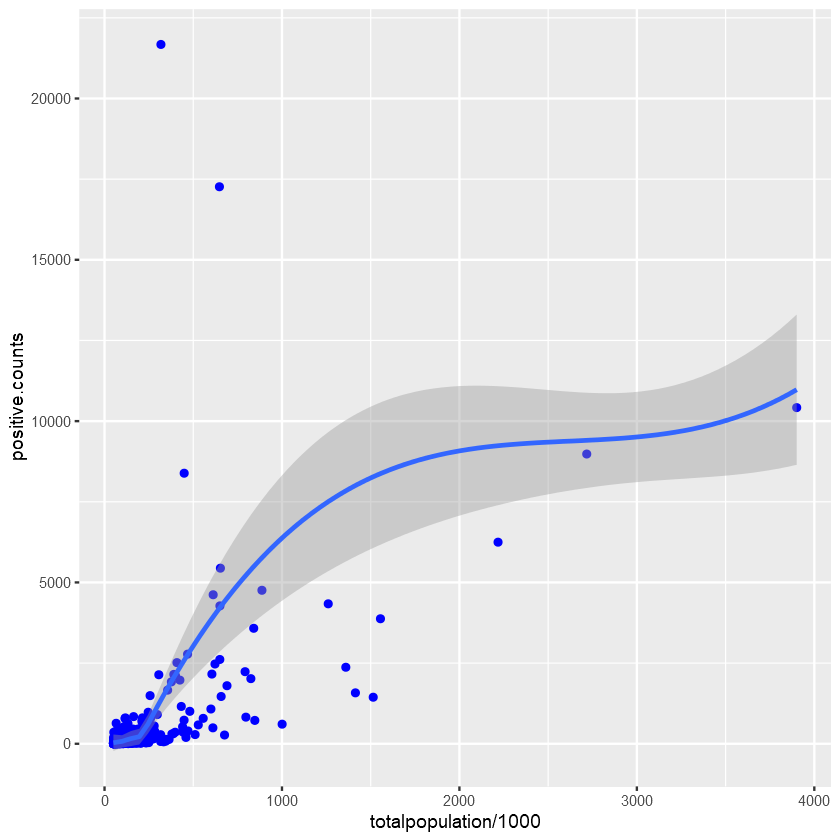

In [86]:
ggplot(aes(x = totalpopulation/1000, y = positive.counts), data = getpop) +
geom_point(color = "blue", fill = "blue") +
geom_smooth()

In [ ]:
#### Check negative binomial results using cities with populations > 50,000

In [88]:
count.pos.pop.50k <- subset(count.pos.pop, totalpopulation >= 50000)# & 
                           #totalpopulation < 8000000)

In [89]:
set.seed(20190126)
train.50k <- count.pos.pop.50k %>%
              #  filter(positive.counts >= 130) %>%
                group_by(location, add = FALSE) %>%
                    dplyr::sample_frac(0.75) %>%
                
            as.data.frame()

In [90]:
test.50k <- count.pos.pop.50k %>%
            #    filter(negative.counts >= 10) %>% 
                anti_join(train.50k) #[sample$id, ]

Joining, by = c("yday", "location", "time", "location_total.counts", "positive.counts", "negative.counts", "neutral.counts", "counts", "lon", "lat", "totalpopulation")


In [91]:
negbin.50k <- glm.nb(positive.counts ~ offset(log(totalpopulation)) + time, 
       data = train.50k, init.theta = 2, link = "log")

In [92]:
summary(negbin.50k)


Call:
glm.nb(formula = positive.counts ~ offset(log(totalpopulation)) + 
    time, data = train.50k, init.theta = 0.4142093074, link = "log")

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4140  -1.0822  -0.6628  -0.1195   9.8616  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -9.914169   0.060427 -164.07   <2e-16 ***
time         0.119486   0.007775   15.37   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for Negative Binomial(0.4142) family taken to be 1)

    Null deviance: 5479.3  on 4676  degrees of freedom
Residual deviance: 5321.5  on 4675  degrees of freedom
AIC: 31826

Number of Fisher Scoring iterations: 1


              Theta:  0.41421 
          Std. Err.:  0.00856 

 2 x log-likelihood:  -31820.26100 

In [93]:
pred.negbin.50k <- predict(negbin.50k, newdata = test.50k, type = "response")

In [94]:
mean(abs(pred.negbin.50k - test.50k$positive.counts))

[1] 31.67356

In [ ]:
Conclusion: 
1. Select negative binomial GLM
2. Use data points where a city's total positive counts >= 130 as the basline model as a 
precursor to STSS
3. Select scanstatistics expectation-based zero inflated poisson for the STSS model as 
    i. It handles both zero-inflated and overdispersed data. 
    ii. In testing it also gave the best results with respect to multiple clusters 
        returning statistically significant Monte-Carlo and Gumbel p-values 